In [1]:
import hana_ml
from hana_ml import dataframe
from data_load_utils import Settings
from hana_ml.algorithms.pal.trees import DecisionTreeClassifier, RandomForestClassifier, HybridGradientBoostingClassifier
from hana_ml.visualizers.model_debriefing import TreeModelDebriefing

url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
connection_context = dataframe.ConnectionContext(url, port, user, pwd)

# Model Debriefing for Decision Tree

## Create Table

In [2]:
table_name = 'PAL_VISUALIZE_DT_DATA_TBL'
create_table_sql = '''CREATE COLUMN TABLE {} (
    "OUTLOOK" VARCHAR(20),
    "TEMP" INTEGER,
    "HUMIDITY" DOUBLE,
    "WINDY" VARCHAR(10),
    "CLASS" VARCHAR(20)
);'''
data = [('Sunny', 75, 70, 'Yes', 'Play'),
       ('Sunny', 80, 90, 'Yes', 'Do not Play'),
       ('Sunny', 85, 85, 'No', 'Do not Play'),
       ('Sunny', 72, 95, 'No', 'Do not Play'),
       ('Sunny', 69, 70, 'No', 'Play'),
       ('Overcast', 72, 90, 'Yes', 'Play'),
       ('Overcast', 83, 78, 'No', 'Play'),
       ('Overcast', 64, 65, 'Yes', 'Play'),
       ('Overcast', 81, 75, 'No', 'Play'),
       ('Rain', 71, 80, 'Yes', 'Do not Play'),
       ('Rain', 65, 70, 'Yes', 'Do not Play'),
       ('Rain', 75, 80, 'No', 'Play'),
       ('Rain', 68, 80, 'No', 'Play'),
       ('Rain', 70, 96, 'No', 'Play')]

In [3]:
cursor = connection_context.connection.cursor()
cursor.execute(create_table_sql.format(table_name))
cursor.executemany("INSERT INTO {} VALUES ({})".format(table_name,', '.join(['?']*len(data[0]))), data)

(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

## Create Data Frame

In [4]:
PAL_DT_DATA_TBL = connection_context.table(table_name)
PAL_DT_DATA_TBL.head(6).collect()

OUTLOOK  TEMP  HUMIDITY WINDY        CLASS
0     Sunny    75      70.0   Yes         Play
1     Sunny    80      90.0   Yes  Do not Play
2     Sunny    85      85.0    No  Do not Play
3     Sunny    72      95.0    No  Do not Play
4     Sunny    69      70.0    No         Play
5  Overcast    72      90.0   Yes         Play

## Generate Model

In [5]:
dtc = DecisionTreeClassifier(algorithm='c45',
                       min_records_of_parent=2, min_records_of_leaf=1,
                       thread_ratio=0.4, split_threshold=1e-5,
                       model_format='json', output_rules=True)

dtc.fit(data=PAL_DT_DATA_TBL, features=['OUTLOOK', 'TEMP', 'HUMIDITY', 'WINDY'], label='CLASS')

In [6]:
PAL_DT_MODEL_TBL = dtc.model_

## Create TreeModelDebriefing Instance

In [7]:
treeModelDebriefing = TreeModelDebriefing()

## Visualize Tree Model in JSON format

In [8]:
treeModelDebriefing.tree_debrief(PAL_DT_MODEL_TBL)

<IPython.core.display.JSON object>

## Visualize Tree Model in DOT format

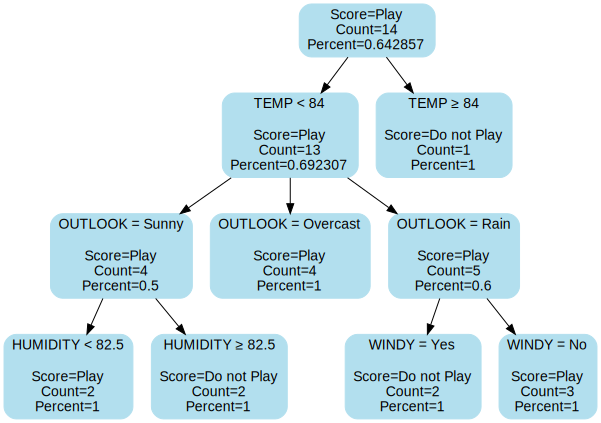

In [9]:
treeModelDebriefing.tree_parse(PAL_DT_MODEL_TBL)
treeModelDebriefing.tree_debrief_with_dot(PAL_DT_MODEL_TBL)

## Export Tree Model as a JSON file

In [13]:
# treeModelDebriefing.tree_export(PAL_DT_MODEL_TBL)

interactive(children=(Text(value='', description='Model File:', placeholder='Enter Name...'), Button(descripti…

## Export Tree Model as a DOT file

In [12]:
# treeModelDebriefing.tree_export_with_dot(PAL_DT_MODEL_TBL)

interactive(children=(Text(value='', description='Model File:', placeholder='Enter Name...'), Button(descripti…

## Visualize Tree Model by a JSON file

In [40]:
# treeModelDebriefing.tree_debrief_from_file('./PAL_DT_MODEL_TBL.json')

<IPython.core.display.JSON object>

## Visualize Tree Model by a DOT file

You can also export the model as a DOT file and use the ZGRViewer tool to view the model.


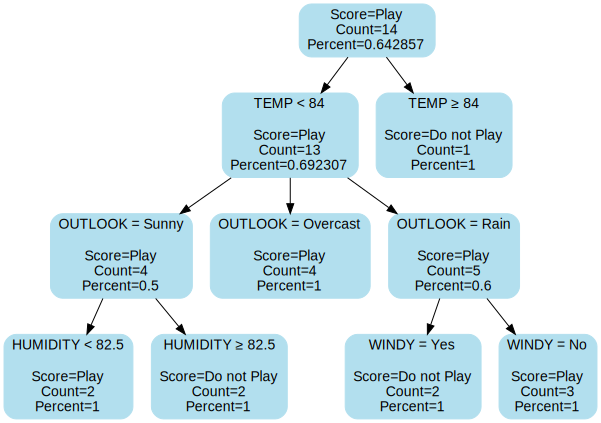

In [14]:
# treeModelDebriefing.tree_debrief_from_file('./PAL_DT_MODEL_TBL.dot')

# Model Debriefing for Random Decision Tree

## Generate Model

In [10]:
rfc = RandomForestClassifier(n_estimators=3,
                             max_features=3, random_state=2,
                             split_threshold=0.00001,
                             calculate_oob=True,
                             min_samples_leaf=1, thread_ratio=1.0)

rfc.fit(data=PAL_DT_DATA_TBL, features=['OUTLOOK', 'TEMP', 'HUMIDITY', 'WINDY'], label='CLASS')

In [11]:
PAL_RDT_MODEL_TBL = rfc.model_

## Visualize Tree Model in XML format

In [12]:
treeModelDebriefing.tree_debrief(PAL_RDT_MODEL_TBL)

interactive(children=(Text(value='0', description='Tree Index:', placeholder=''), Output()), _dom_classes=('wi…

## Visualize Tree Model in DOT format

In [13]:
treeModelDebriefing.tree_parse(PAL_RDT_MODEL_TBL)
treeModelDebriefing.tree_debrief_with_dot(PAL_RDT_MODEL_TBL)

interactive(children=(Text(value='0', description='Tree Index:', placeholder=''), Output()), _dom_classes=('wi…

## Detele Table

In [14]:
delete_table_sql = 'DROP TABLE {}'
cursor.execute(delete_table_sql.format(table_name))

True

# Model Debriefing for Hybrid Gradient Boosting Tree

## Create Table

In [15]:
table_name = 'PAL_VISUALIZE_HGBT_DATA_TBL'
create_table_sql = '''CREATE COLUMN TABLE {} (
    "ATT1" DOUBLE, 
    "ATT2" DOUBLE, 
    "ATT3" DOUBLE,
    "ATT4" DOUBLE,
    "LABEL" varchar(50)
);'''
data = [(1.0, 10.0, 100, 1.0, 'A'),
       (1.1, 10.1, 100, 1.0, 'A'),
       (1.2, 10.2, 100, 1.0, 'A'),
       (1.3, 10.4, 100, 1.0, 'A'),
       (1.2, 10.3, 100, 1.0, 'A'),
       (4.0, 40.0, 400, 4.0, 'B'),
       (4.1, 40.1, 400, 4.0, 'B'),
       (4.2, 40.2, 400, 4.0, 'B'),
       (4.3, 40.4, 400, 4.0, 'B'),
       (4.2, 40.3, 400, 4.0, 'A'),
       (9.0, 90.0, 900, 2.0, 'A'),
       (9.1, 90.1, 900, 1.0, 'B'),
       (9.2, 90.2, 900, 2.0, 'B'),
       (9.3, 90.4, 900, 1.0, 'B'),
       (9.2, 90.3, 900, 1.0, 'B')]

In [16]:
cursor = connection_context.connection.cursor()
cursor.execute(create_table_sql.format(table_name))
cursor.executemany("INSERT INTO {} VALUES ({})".format(table_name,', '.join(['?']*len(data[0]))), data)

(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

## Create Data Frame

In [17]:
PAL_HGBT_DATA_TBL = connection_context.table(table_name)
PAL_HGBT_DATA_TBL.head(6).collect()

ATT1  ATT2   ATT3  ATT4 LABEL
0   1.0  10.0  100.0   1.0     A
1   1.1  10.1  100.0   1.0     A
2   1.2  10.2  100.0   1.0     A
3   1.3  10.4  100.0   1.0     A
4   1.2  10.3  100.0   1.0     A
5   4.0  40.0  400.0   4.0     B

## Generate Model

In [18]:
hgbt = HybridGradientBoostingClassifier(n_estimators = 4, split_threshold=0,
            learning_rate=0.5, fold_num=5, max_depth=6,
            cv_metric = 'error_rate', ref_metric=['auc'],
            cross_validation_range=[('learning_rate',[0.1, 1.0, 3]),
            ('n_estimators', [4, 10, 3]),
            ('split_threshold', [0.1, 1.0, 3])])
hgbt.fit(data=PAL_HGBT_DATA_TBL, features=['ATT1', 'ATT2', 'ATT3', 'ATT4'], label='LABEL')

In [19]:
PAL_HGBT_MODEL_TBL = hgbt.model_

## Visualize Tree Model in JSON format

In [20]:
treeModelDebriefing.tree_debrief(PAL_HGBT_MODEL_TBL)

interactive(children=(Text(value='0', description='Tree Index:', placeholder=''), Output()), _dom_classes=('wi…

## Visualize Tree Model in DOT format

In [21]:
treeModelDebriefing.tree_parse(PAL_HGBT_MODEL_TBL)
treeModelDebriefing.tree_debrief_with_dot(PAL_HGBT_MODEL_TBL)

interactive(children=(Text(value='0', description='Tree Index:', placeholder=''), Output()), _dom_classes=('wi…

## Delete Table

In [29]:
delete_table_sql = 'DROP TABLE {}'
cursor.execute(delete_table_sql.format(table_name))

True